### Imports and logging

In [1]:
import logging

logging.basicConfig(level=logging.INFO)

logger = logging.getLogger(__name__)
logger.setLevel(logging.DEBUG)

In [2]:
import os
import torch

# We set up CUDA first to ensure it is configured correctly
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
if torch.cuda.is_available():
    CUDA_DEVICE = torch.device("cuda:0")
    logger.info(f"CUDA is available. Using device: {CUDA_DEVICE}")
else:
    logger.error("CUDA is not available. Please check your PyTorch installation. Using CPU instead...this will be slow.")
    CUDA_DEVICE = torch.device("cpu")

INFO:__main__:CUDA is available. Using device: cuda:0


In [3]:
from pipeline.proj import load_projection_mat, reformat_sinogram, interpolate_projections, pad_and_reshape, divide_sinogram
from pipeline.aggregate_prj import aggregate_saved_projections
from pipeline.aggregate_ct import aggregate_saved_recons
from pipeline.apply_model import apply_model_to_projections, load_model, apply_model_to_recons
from pipeline.utils import ensure_dir, read_scans_agg_file
from pipeline.paths import Directories, Files
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import yaml
import importlib
import copy
from tqdm import tqdm
import gc
import tigre.utilities.gpu as gpu
from pipeline.FDK_half.FDK_half import FDKHalf
from pipeline.utils import get_geometry
import time

### Pick scan

In [4]:
PHASE = '7'
DATA_VERSION = '13'
PATIENT = '20'
SCAN = '01'
SCAN_TYPE = 'HF'
PD_MODEL_VERSION = 'MK7_07'
PD_NETWORK_NAME = 'IResNet'
ID_MODEL_VERSION = 'MK7_07'
ID_NETWORK_NAME = 'IResNet'

### File system

In [5]:
# Base directory
WORK_ROOT = "D:/NoahSilverberg/ngCBCT"

# NSG_CBCT Path where the raw matlab data is stored
NSG_CBCT_PATH = "D:/MitchellYu/NSG_CBCT"

# Directory with all files specific to this phase/data version
PHASE_DATAVER_DIR = os.path.join(
    WORK_ROOT, f"phase{PHASE}", f"DS{DATA_VERSION}"
)

DIRECTORIES = Directories(
    mat_projections_dir=os.path.join(NSG_CBCT_PATH, "data/prj/HF/mat"),
    pt_projections_dir=os.path.join(WORK_ROOT, "prj_pt"),
    projections_aggregate_dir=os.path.join(PHASE_DATAVER_DIR, "aggregates", "projections"),
    projections_model_dir=os.path.join(PHASE_DATAVER_DIR, "models", "projections"),
    projections_results_dir=os.path.join(PHASE_DATAVER_DIR, "results", "projections"),
    projections_gated_dir=os.path.join(WORK_ROOT, "gated", "prj_mat"),
    reconstructions_dir=os.path.join(PHASE_DATAVER_DIR, "reconstructions"),
    reconstructions_gated_dir=os.path.join(WORK_ROOT, "gated", "fdk_recon"),
    images_aggregate_dir=os.path.join(PHASE_DATAVER_DIR, "aggregates", "images"),
    images_model_dir=os.path.join(PHASE_DATAVER_DIR, "models", "images"),
    images_results_dir=os.path.join(PHASE_DATAVER_DIR, "results", "images"),
)

FILES = Files(DIRECTORIES)

### Run

In [6]:
start_time = time.perf_counter()

In [7]:
### Load PD model

model_path = FILES.get_model_filepath(PD_MODEL_VERSION, "PROJ")
PD_model = load_model(PD_NETWORK_NAME, model_path, CUDA_DEVICE)

pd_model_load_time = time.perf_counter()

In [ ]:
### Load scans and apply PD model

mat_path = FILES.get_projection_mat_filepath(PATIENT, SCAN, SCAN_TYPE)
gated_pt_path = FILES.get_projection_pt_filepath(PATIENT, SCAN, SCAN_TYPE, gated=True)
ng_pt_path = FILES.get_projection_pt_filepath(PATIENT, SCAN, SCAN_TYPE, gated=False)

odd_index, angles = load_projection_mat(mat_path, exclude_prj=True)

prj_gcbct = torch.load(gated_pt_path).detach()
prj_ngcbct_li = torch.load(ng_pt_path).detach()

_, cnn_mat = apply_model_to_projections(PD_model, SCAN_TYPE, odd_index, angles, prj_gcbct, prj_ngcbct_li, CUDA_DEVICE)

pd_model_apply_time = time.perf_counter()

In [9]:
### FDK

if SCAN_TYPE == 'HF':
    fdk = FDKHalf()(cnn_mat['prj'], get_geometry(), cnn_mat['angles'].flatten(), filter="hann", parker=True)
    fdk = torch.from_numpy(fdk).detach().to(CUDA_DEVICE)
    fdk = fdk.unsqueeze(1) # Add channel dimension
else:
    raise NotImplementedError

fdk_time = time.perf_counter()

In [10]:
### Load ID model

model_path = FILES.get_model_filepath(ID_MODEL_VERSION, 'IMAG')

ID_model = load_model(ID_NETWORK_NAME, model_path, CUDA_DEVICE)

id_model_load_time = time.perf_counter()

In [11]:
### Pass FDK through ID model

# Loop over the outputted slices in batches of 8
id_output = torch.zeros_like(fdk, device=CUDA_DEVICE)
for i in range(0, fdk.shape[0], 8):
    # Adjust the batch size for the last batch to avoid going out of bounds
    batch_size = min(8, fdk.shape[0] - i)
    indices = [i + j for j in range(batch_size)]
    with torch.no_grad():
        id_output[indices] = ID_model(fdk[indices].clip(0, 0.04) * 25.) # replace the slices in place

id_model_apply_time = time.perf_counter()

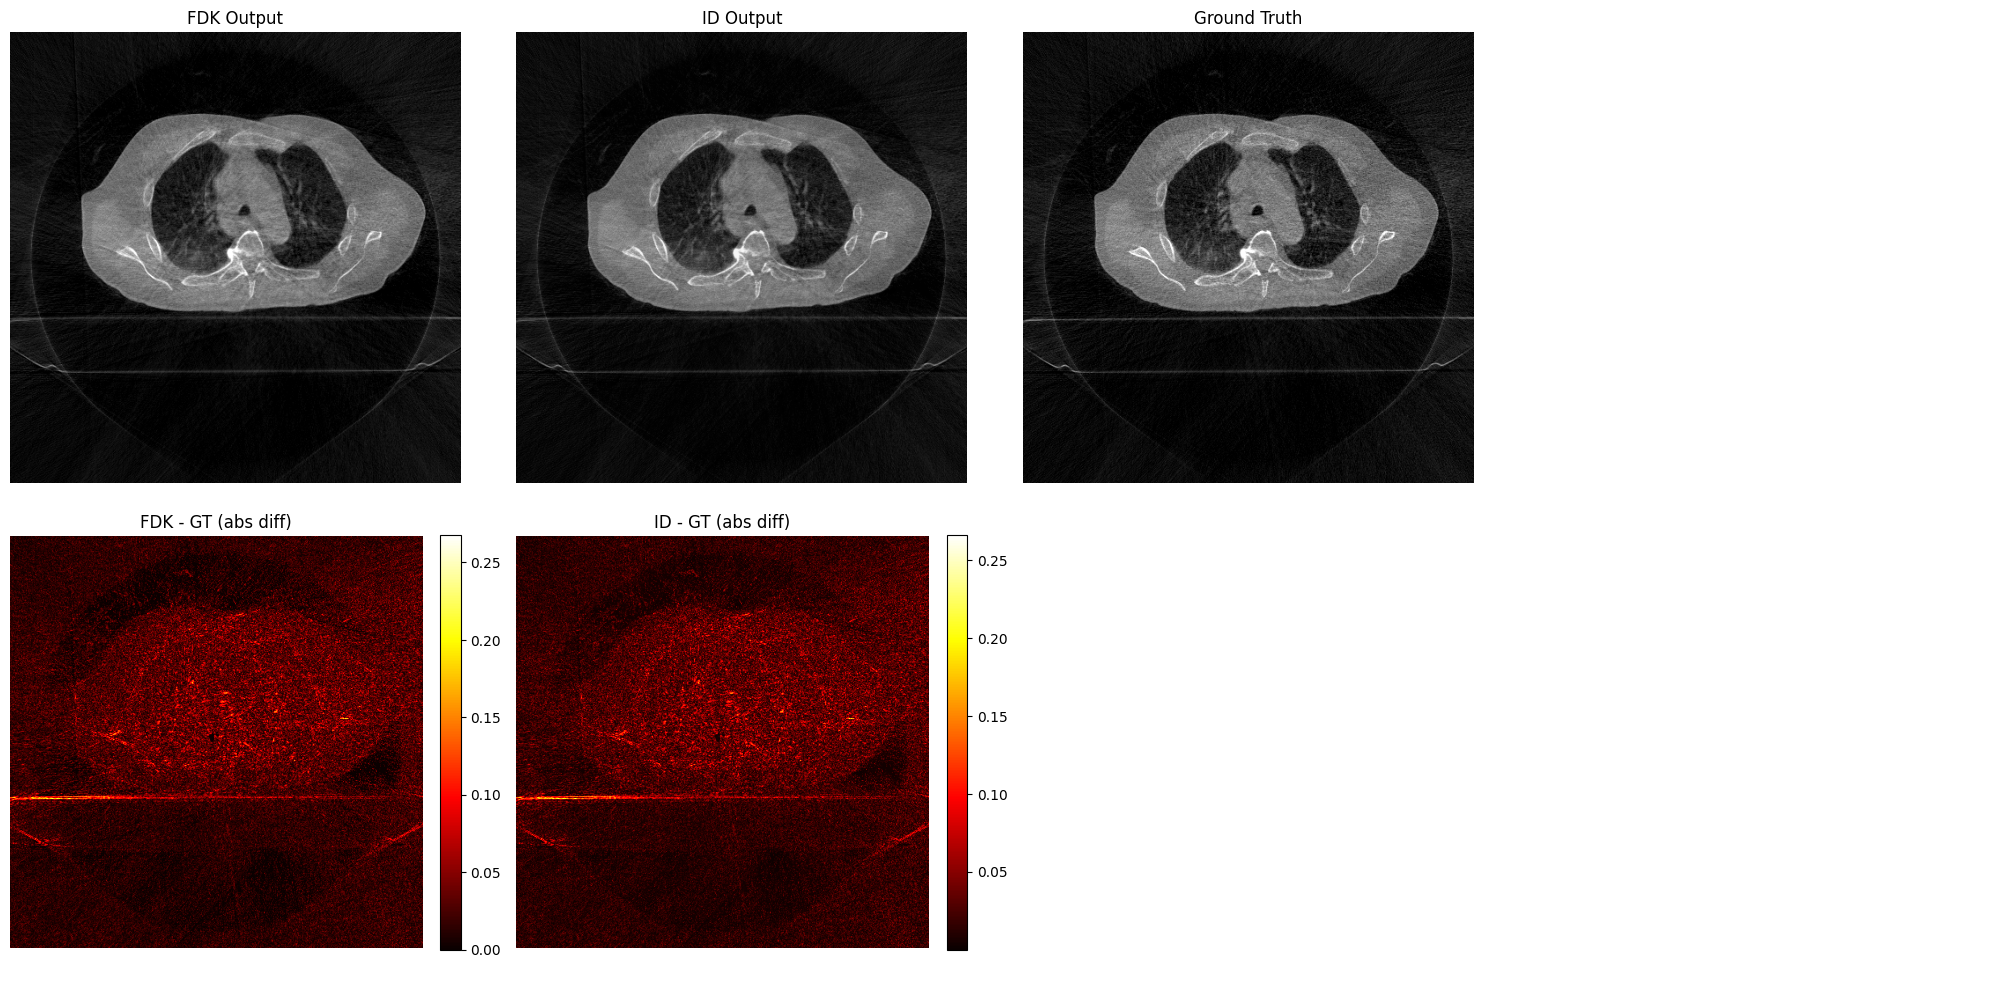

FDK vs GT:   PSNR = 30.23, SSIM = 0.7929
ID  vs GT:   PSNR = 30.34, SSIM = 0.7958


In [12]:
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

### Load ground truth
gt_path = FILES.get_recon_filepath('fdk', PATIENT, SCAN, SCAN_TYPE, gated=True)
gt = torch.load(gt_path).cpu().numpy()

### Plot result (80-th slice)
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

slice_idx = 80

# FDK output (before image domain network)
fdk_img = 25. * fdk[slice_idx, 0].clip(0, 0.04).T.cpu().numpy()
axs[0, 0].imshow(fdk_img, cmap='gray')
axs[0, 0].set_title("FDK Output")
axs[0, 0].axis('off')

# ID output (after image domain network)
id_img = id_output[slice_idx, 0].T.cpu().numpy()
axs[0, 1].imshow(id_img, cmap='gray')
axs[0, 1].set_title("ID Output")
axs[0, 1].axis('off')

# Ground truth
gt_img = 25. * gt[slice_idx].T.clip(0, 0.04)
axs[0, 2].imshow(gt_img, cmap='gray')
axs[0, 2].set_title("Ground Truth")
axs[0, 2].axis('off')

# Difference maps
diff_fdk = np.abs(fdk_img - gt_img)
diff_id = np.abs(id_img - gt_img)
axs[1, 0].imshow(diff_fdk, cmap='hot')
axs[1, 0].set_title("FDK - GT (abs diff)")
axs[1, 0].axis('off')
axs[1, 1].imshow(diff_id, cmap='hot')
axs[1, 1].set_title("ID - GT (abs diff)")
axs[1, 1].axis('off')

# Colorbars for difference maps
fig.colorbar(axs[1, 0].imshow(diff_fdk, cmap='hot'), ax=axs[1, 0], fraction=0.046, pad=0.04)
fig.colorbar(axs[1, 1].imshow(diff_id, cmap='hot'), ax=axs[1, 1], fraction=0.046, pad=0.04)

# Hide unused subplots
for ax in [axs[0, 3], axs[1, 2], axs[1, 3]]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# Compute PSNR and SSIM

psnr_fdk = psnr(gt_img, fdk_img, data_range=1.)
psnr_id = psnr(gt_img, id_img, data_range=1.)
ssim_fdk = ssim(gt_img, fdk_img, data_range=1.)
ssim_id = ssim(gt_img, id_img, data_range=1.)

print(f"FDK vs GT:   PSNR = {psnr_fdk:.2f}, SSIM = {ssim_fdk:.4f}")
print(f"ID  vs GT:   PSNR = {psnr_id:.2f}, SSIM = {ssim_id:.4f}")

In [13]:
### Print timings
steps = [
    ("Load PD model", pd_model_load_time - start_time),
    ("Apply PD model", pd_model_apply_time - pd_model_load_time),
    ("FDK", fdk_time - pd_model_apply_time),
    ("Load ID model", id_model_load_time - fdk_time),
    ("Apply ID model", id_model_apply_time - id_model_load_time),
]

cumulative_time = 0
print(f"{'Step':<20}|{'Time (s)':<15}|{'Cumulative Time (s)':<20}")
print("-" * 55)
for step, duration in steps:
    cumulative_time += duration
    print(f"{step:<20}|{duration:<15.2f}|{cumulative_time:<20.2f}")

Step                |Time (s)       |Cumulative Time (s) 
-------------------------------------------------------
Load PD model       |0.88           |0.88                
Apply PD model      |31.08          |31.96               
FDK                 |18.58          |50.54               
Load ID model       |0.68           |51.23               
Apply ID model      |5.25           |56.48               
